# ARIMA vs SARIMA 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from itertools import combinations

from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format

In [2]:
def evaluate(d):
    mse_f = np.mean(d**2)
    mae_f = np.mean(abs(d))
    rmse_f = np.sqrt(mse_f)
    print("MAE:",mae_f)
    print("MSE:", mse_f)
    print("RMSE:", rmse_f)

In [3]:
# import data
data = pd.read_csv('airline_passengers.csv',infer_datetime_format=True,parse_dates=["Month"],index_col=["Month"])

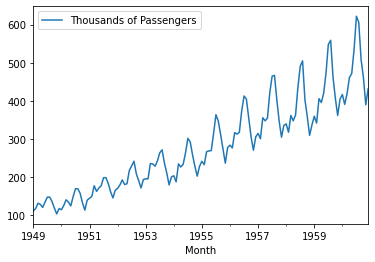

In [4]:
data.plot()

In [5]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Data')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

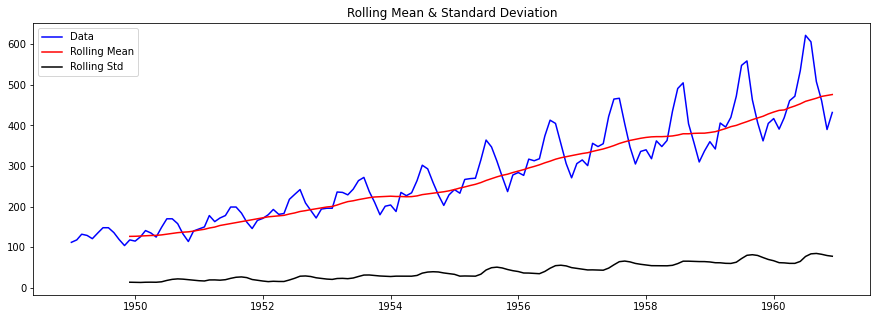

Results of Dickey-Fuller Test:
Test Statistic          0.82
p-value                 0.99
Critical Value (1%)    -3.48
Critical Value (5%)    -2.88
Critical Value (10%)   -2.58
dtype: float64


In [6]:
test_stationarity(data['Thousands of Passengers'])

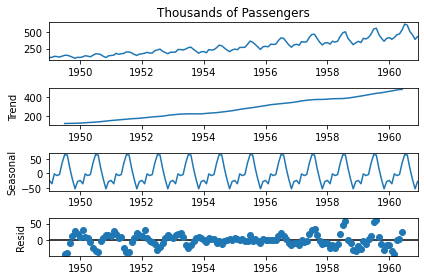

In [7]:
dec = sm.tsa.seasonal_decompose(data['Thousands of Passengers'],period = 12).plot()
plt.show()

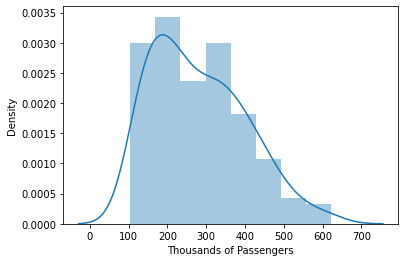

In [8]:
sns.distplot(data['Thousands of Passengers'])

- data is not stationary as the test statistic values is higher than any of the critical values
- also the p-value is not less than 0.5
- data has an increasing trend
- data has also a seasonality, with a pattern of 1 year

### Differencing

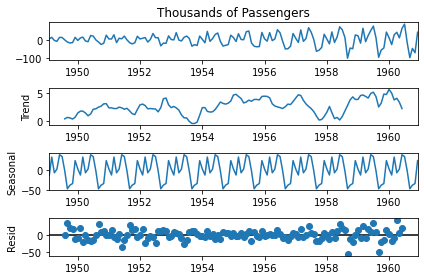

In [9]:
data_diff = data['Thousands of Passengers'].diff()
data_diff = data_diff.dropna()
dec = sm.tsa.seasonal_decompose(data_diff,period = 12).plot()
plt.show()

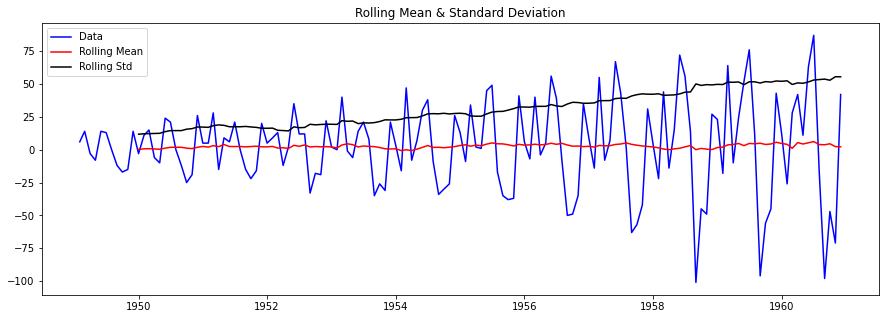

Results of Dickey-Fuller Test:
Test Statistic         -2.83
p-value                 0.05
Critical Value (1%)    -3.48
Critical Value (5%)    -2.88
Critical Value (10%)   -2.58
dtype: float64


In [10]:
test_stationarity(data_diff)

- trend has died down and is constant
- test statistc < critical value(10%) --> data is 90% surely stationary
- P-Value = 0.05
- rolling is also constant, hence data is stationary
- However seasonality is still present

In [11]:
# function for plotting acf and pacf plot to find the order of ARIMA models
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

## ARIMA [p,d,q]

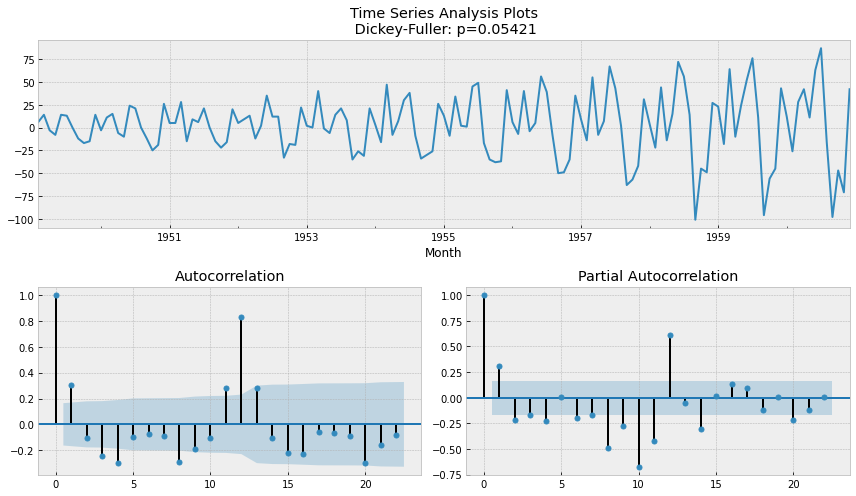

In [12]:
tsplot(data_diff)

ARIMA MODEL ORDER [p,d,q]
- p = Partial Autocorrelation plot = lag value at which the line touches the confidence interval first
- d = Differencing order
- q = Autocorrelation plot = lag value at which the line touches the confidence interval first
- look at AIC and BIC scores, to understand which is the best model

The order of ARIMA model would be around: 
- p = 1-2
- d = 1
- q = 1-2

In [13]:
model = ARIMA(data, order = (2,1,2))
model_fit = model.fit()
print(model_fit.summary())

                                 ARIMA Model Results                                 
Dep. Variable:     D.Thousands of Passengers   No. Observations:                  143
Model:                        ARIMA(2, 1, 2)   Log Likelihood                -666.022
Method:                              css-mle   S.D. of innovations             24.712
Date:                       Thu, 16 Dec 2021   AIC                           1344.043
Time:                               12:44:58   BIC                           1361.820
Sample:                           02-01-1949   HQIC                          1351.267
                                - 12-01-1960                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               2.5311      0.708      3.574      0.000       1.143       3.919
ar.L1.D.Thou

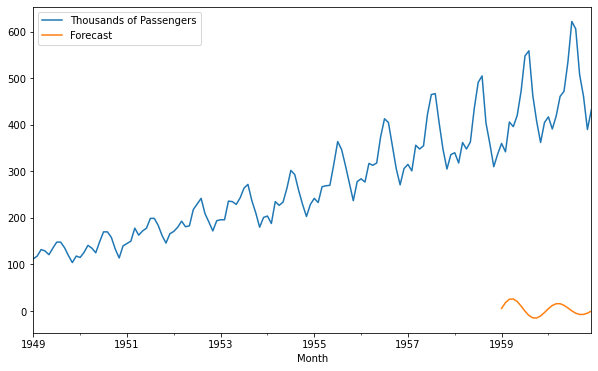

In [14]:
data['Forecast'] = model_fit.predict(start = 120,end = 144,dynamic = True)
data[['Thousands of Passengers','Forecast']].plot(figsize = (10,6))

In [15]:
exp = [data.iloc[i,0] for i in range(120,len(data))]
pred = [data.iloc[i,1] for i in range(120,len(data))]
data = data.drop(columns = 'Forecast')
print(mean_absolute_error(exp,pred))

448.26942192678416


- the prediction plot is not good at all
- MAE (Mean Absolute Error) is also high, this is due to the seasonality
- for these reasons, we move onto SARIMA which handles seasonality

## SARIMA [(p,d,q)x(P,D,Q,s)]

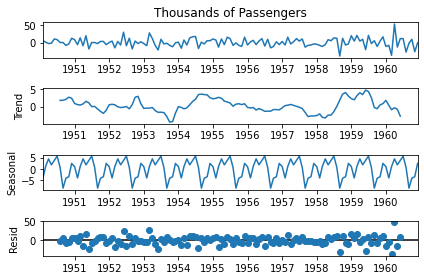

In [16]:
data_diff_seas = data_diff.diff(12)
data_diff_seas = data_diff_seas.dropna()
dec = sm.tsa.seasonal_decompose(data_diff_seas,period = 12)
dec.plot()
plt.show()

- seasonal difference with a seasonal period of 12
- from the plots we observe that a yearly pattern is present

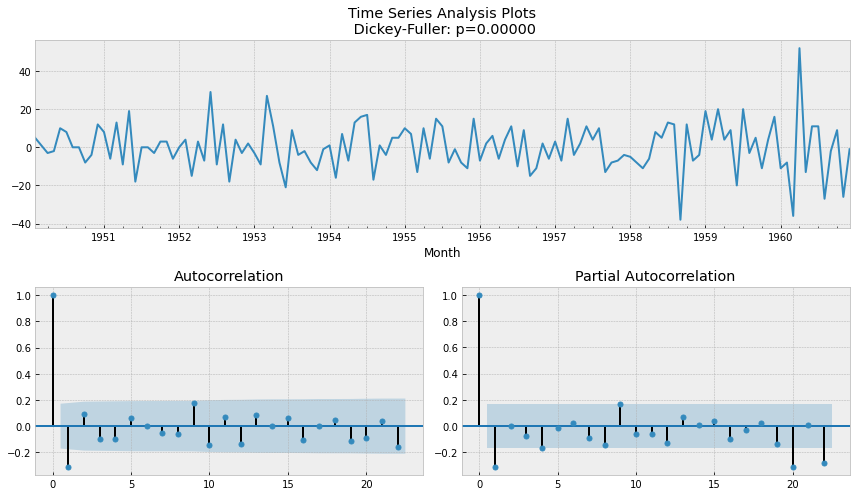

In [17]:
tsplot(data_diff_seas)

SARIMA MODEL ORDER [(p,d,q)x(P,D,Q,s)]
- (p,d,q) = this order is inherited from our above arima model
- (P,D,Q,s) = this order is selected using the same techniques used above for ARIMA
- s = is the seasonal order
- Look at AIC and BIC scores, to understand which is the best model

In [18]:
model = sm.tsa.statespace.SARIMAX(data['Thousands of Passengers'],order = (2,1,2),seasonal_order = (1,1,2,12))
results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:            Thousands of Passengers   No. Observations:                  144
Model:             SARIMAX(2, 1, 2)x(1, 1, 2, 12)   Log Likelihood                -498.994
Date:                            Thu, 16 Dec 2021   AIC                           1013.988
Time:                                    12:45:01   BIC                           1036.989
Sample:                                01-01-1949   HQIC                          1023.334
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6117      0.410      1.490      0.136      -0.193       1.416
ar.L2          0.2195      0.289   

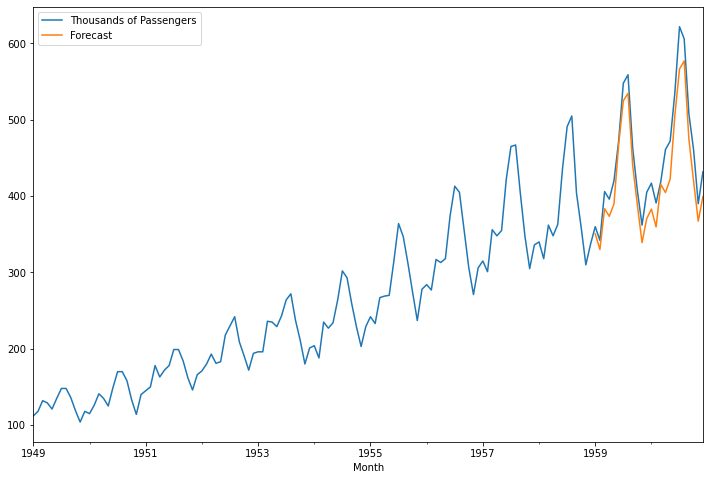

In [19]:
data['Forecast'] = results.predict(start = 120,end = 144,dynamic = True)
data[['Thousands of Passengers','Forecast']].plot(figsize = (12,8))

In [20]:
exp = [data.iloc[i,0] for i in range(120,len(data))]
pred = [data.iloc[i,1] for i in range(120,len(data))]
data = data.drop(columns = 'Forecast')
print(mean_absolute_error(exp,pred))

27.735929921084846


- the predicted plot is much better
- error has also reduced a lot

## FORECASTING

In [21]:
from pandas.tseries.offsets import DateOffset

# add dates to our dataframe for our forecasting purpose
future_dates = [data.index[-1] + DateOffset(months = x) for x in range(0,25)]
df = pd.DataFrame(index = future_dates[1:],columns = data.columns)

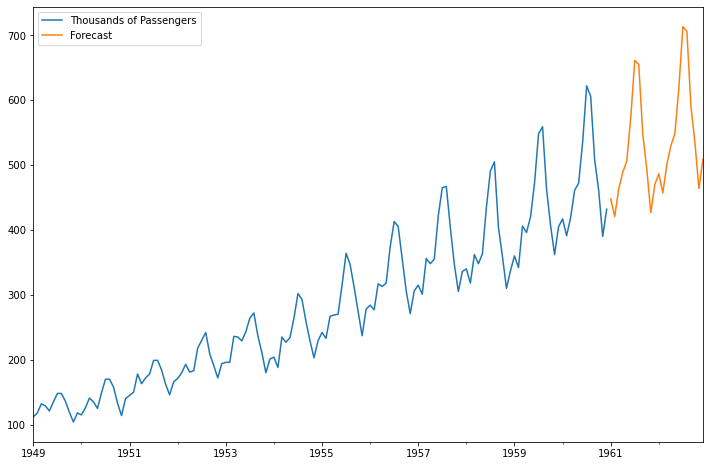

In [22]:
forecast = pd.concat([data,df])
forecast['Forecast'] = results.predict(start = 144,end = 168,dynamic = True)
forecast[['Thousands of Passengers','Forecast']].plot(figsize = (12,8))